In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from stacked_mnist import StackedMNISTData, DataMode
from verification_net import VerificationNet
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from auto_encoder import AutoEncoder
from vae import VariationalAutoEncoder
import tensorflow_probability as tfp
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
import utils

## Generate datasets

In [3]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

### Validation network
Train the validation network

In [4]:
valid_net = VerificationNet(force_learn=False)
valid_net.train(generator=gen, epochs=100)

img, labels = gen.get_random_batch(training=True,  batch_size=25000)
cov = valid_net.check_class_coverage(data=img, tolerance=.98)
pred, acc = valid_net.check_predictability(data=img, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 99.03%
Accuracy: 98.79%


# Auto Encoder

In [5]:
ae = AutoEncoder(force_learn=False, file_name="./models/ae_10_relu")

ae.train(x_train=x_train, x_test=x_test, epochs=25)

Read model from file, so I do not retrain
Read model from file, so I do not retrain


True

### Reconstruction
Use the verification net to validate the reconstruction ability of the Auto Encoder

#### Mono

In [6]:
img, labels = gen.get_random_batch(training=False,  batch_size=10000)

reconstructed = ae.autoencode(img)

cov = valid_net.check_class_coverage(data=reconstructed, tolerance=.80)
pred, acc = valid_net.check_predictability(data=reconstructed, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 90.13%
Accuracy: 84.97%


#### Plots

Plot the original and reconstructed images

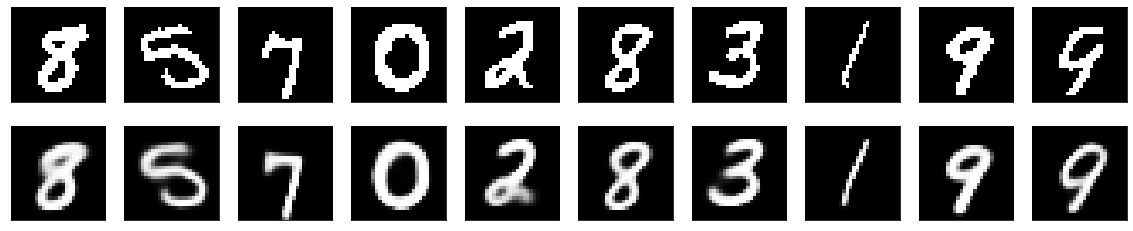

In [7]:
utils.plot_10_images(img, reconstructed,filename='AE_Reconstruct.png', random=True )

#### Color


In [ ]:
gen = StackedMNISTData(
    mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

In [ ]:
img, labels = gen.get_random_batch(training=False,  batch_size=10000)

reconstructed = ae.autoencode(img)

cov = valid_net.check_class_coverage(data=reconstructed, tolerance=.50)
pred, acc = valid_net.check_predictability(data=reconstructed, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

In [ ]:
utils.plot_10_images(img.astype(np.float32), reconstructed,filename='AE_Reconstruct_color.png', random=True )

### Generative model

By sending values into the decoder, we can try to generate new images

In [ ]:
generated = ae.generate_images(10000, no_channels=1)

Evaluate the images with the verification network

In [ ]:
cov = valid_net.check_class_coverage(data=generated, tolerance=.80)
pred, acc = valid_net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

#### Plots
Plot some of the generated images


In [ ]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(generated[i])
plt.savefig('plots/AE_generated_mono')
plt.show()

#### Color

In [ ]:
generated = ae.generate_images(10000, no_channels=3)
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(generated[i])
plt.savefig('plots/AE_generated_color')
plt.show()

In [ ]:
enc = ae.encode(img)

(Get max z value for use when creating random vectors)

In [ ]:
enc.max()

### Anomaly detection

First, we train the AE on a dataset with a missing number.

In [8]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_MISSING, default_batch_size=2048)

x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

In [9]:
ae = AutoEncoder(force_learn=False, file_name="./models/ae_missing")

Read model from file, so I do not retrain


In [10]:
ae.train(x_train=x_train, x_test=x_test, epochs=25)

Read model from file, so I do not retrain


True

In [41]:
gen = StackedMNISTData(
    mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)

img, labels = gen.get_random_batch(training=False,  batch_size=2000)

In [42]:
loss = keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="none",
    name="binary_crossentropy",
)

In [45]:
reconstructed = ae.autoencode(img)
losses = loss(img, reconstructed)
losses = np.average(losses, axis=1)
losses = np.average(losses, axis=1)

(2000, 28, 28)


In [46]:
indices = np.argpartition(losses, -10)[-11:]

In [47]:
losses

array([0.06303445, 0.08765268, 0.04271942, ..., 0.07003618, 0.03042211,
       0.10383939], dtype=float32)

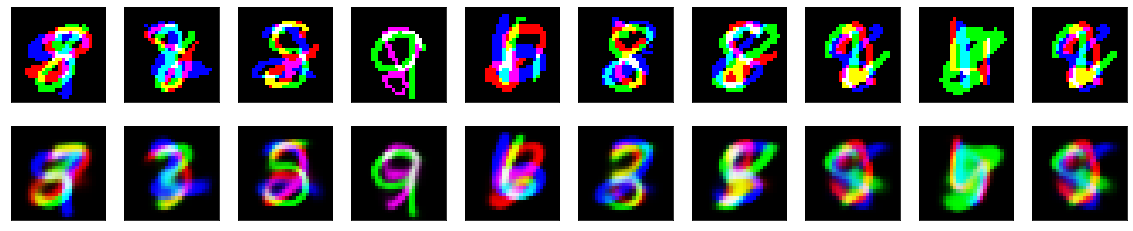

In [48]:
utils.plot_10_images(img[indices].astype(np.float32), reconstructed[indices], filename='AE_anomalies')

## Variational Auto Encoder

In [ ]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

In [54]:
vae = VariationalAutoEncoder(force_learn=False, file_name="./models/vae_8")

Read model from file, so I do not retrain


In [ ]:
vae.train(x_train=x_train, x_test=x_test, epochs=20)

In [55]:
img, labels = gen.get_random_batch(training=False,  batch_size=10000)

reconstructed = vae.autoencode(img)

cov = valid_net.check_class_coverage(data=reconstructed, tolerance=.80)
pred, acc = valid_net.check_predictability(data=reconstructed, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

Coverage: 100.00%
Predictability: 97.45%
Accuracy: 90.54%


In [ ]:
utils.plot_10_images(img, reconstructed, filename='VAE_Reconstruct_mono', random=True)

#### Color

In [ ]:
gen = StackedMNISTData(
    mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=2048)

img, labels = gen.get_random_batch(training=False,  batch_size=10000)

reconstructed = vae.autoencode(img)

cov = valid_net.check_class_coverage(data=reconstructed, tolerance=.50)
pred, acc = valid_net.check_predictability(data=reconstructed, correct_labels=labels)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")
print(f"Accuracy: {100 * acc:.2f}%")

In [ ]:
utils.plot_10_images(img.astype(np.float32), reconstructed, filename='VAE_Reconstruct_color', random=True)

### VAE as Generative model

In [56]:
generated = vae.generate_images(10000, no_channels=1)

In [305]:
cov = valid_net.check_class_coverage(data=generated, tolerance=.80)
pred, acc = valid_net.check_predictability(data=generated)
print(f"Coverage: {100*cov:.2f}%")
print(f"Predictability: {100*pred:.2f}%")

Coverage: 100.00%
Predictability: 82.35%


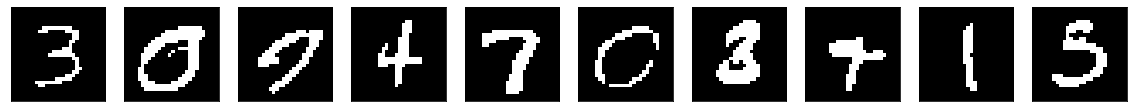

In [57]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(generated[i])
plt.savefig('plots/VAE_generated_mono')
plt.show()

#### Color

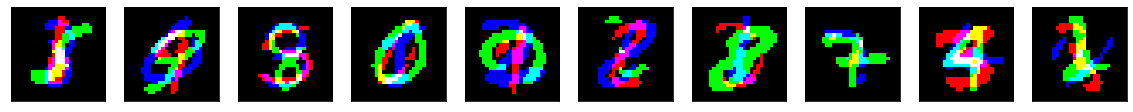

In [330]:
generated = vae.generate_images(10000, no_channels=3)
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(generated[i])
plt.savefig('plots/VAE_generated_color')
plt.show()

### Anomaly detection

In [49]:
loss = keras.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction="none",
    name="binary_crossentropy",
)

In [85]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_MISSING, default_batch_size=2048)

x_train, y_train = gen.get_full_data_set(training=True)
x_test, y_test = gen.get_full_data_set(training=False)

In [86]:
vae = VariationalAutoEncoder(force_learn=False, file_name="./models/vae_missing_8")

Could not read weights for autoencoder from file. Must retrain...


In [87]:
vae.train(x_train=x_train, x_test=x_test, epochs=20)

Could not read weights for autoencoder from file. Must retrain...
Epoch 1/20
106/106 [==============================] - 9s 44ms/step - loss: 260.2625 - accuracy: 0.8699 - val_loss: 208.1411 - val_accuracy: 0.8658
Epoch 2/20
106/106 [==============================] - 4s 34ms/step - loss: 176.5240 - accuracy: 0.8862 - val_loss: 147.8088 - val_accuracy: 0.9213
Epoch 3/20
106/106 [==============================] - 4s 34ms/step - loss: 132.2355 - accuracy: 0.9345 - val_loss: 129.6729 - val_accuracy: 0.9371
Epoch 4/20
106/106 [==============================] - 4s 35ms/step - loss: 122.5381 - accuracy: 0.9426 - val_loss: 125.2291 - val_accuracy: 0.9405
Epoch 5/20
106/106 [==============================] - 4s 35ms/step - loss: 118.5263 - accuracy: 0.9457 - val_loss: 122.6521 - val_accuracy: 0.9420
Epoch 6/20
106/106 [==============================] - 4s 34ms/step - loss: 115.8846 - accuracy: 0.9478 - val_loss: 120.2789 - val_accuracy: 0.9453
Epoch 7/20
106/106 [==============================] 

True

In [100]:
gen = StackedMNISTData(
    mode=DataMode.MONO_BINARY_COMPLETE, default_batch_size=2048)

In [101]:
img, labels = gen.get_random_batch(training=False, batch_size=1000)

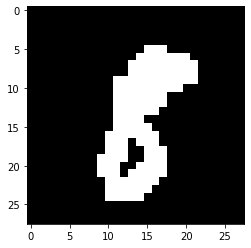

In [109]:
plt.imshow(img[labels == 8][5])

In [102]:
N = 1000
p_x = np.zeros(len(img))
for i in range(len(img)):

    z = np.random.randn(1, 8)
    dec = vae.decode_channel(z)
    I = img[i:i+1].repeat(N, axis=0)
    p = loss(I,dec)# Shape=(N,28,28)
    p = np.average(p, axis=1) # Shape=(N, 28)
    p = np.average(p, axis=1) # Shape = (N,)

    p = np.exp(-p)
    p = np.average(p)
    p_x[i] = p 

    

    

In [103]:
indices = np.argpartition(p_x, 10)[:11]

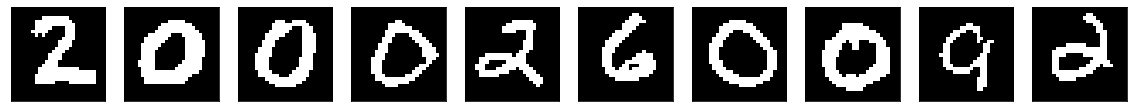

In [104]:
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(img[indices[i]])
plt.savefig('plots/VAE_anomalies')
plt.show()